In [2]:
!pip install --upgrade --no-cache-dir recsim

You should consider upgrading via the '/raid/home/aayush/git/fitapp_analysis/fitapp_aayush/bin/python -m pip install --upgrade pip' command.


In [3]:
import numpy as np
from gym import spaces
import matplotlib.pyplot as plt
from scipy import stats
import random

In [4]:
from recsim import document
from recsim import user
from recsim.choice_model import MultinomialLogitChoiceModel
from recsim.simulator import environment
from recsim.simulator import recsim_gym

2022-10-24 18:34:18.720683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /raid/home/aayush/git/fitapp_analysis/fitapp_aayush/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-24 18:34:18.720717: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/aayush/git/fitapp_analysis/fitapp_aayush/lib/python3.9/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/aayush/git/fitapp_analysis/fitapp_aayush/lib/python3.9/site-packages/keras/utils/image_utils.py:36: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil

In [36]:
class LTSDocument(document.AbstractDocument):
  def __init__(self, doc_id, genre):
    self.genre = genre
    # doc_id is an integer representing the unique ID of this document
    super(LTSDocument, self).__init__(doc_id)

  def create_observation(self):
    return self.genre
    #return np.array([self.genre])

  @staticmethod
  def observation_space():
    return spaces.Discrete(10)
    #return spaces.Box(shape=(1,), dtype=np.float32, low=0.0, high=1.0)
  
  def __str__(self):
    return "Music {} with genre {}.".format(self._doc_id, self.genre)

In [38]:
class LTSDocumentSampler(document.AbstractDocumentSampler):
  def __init__(self, doc_ctor=LTSDocument, **kwargs):
    super(LTSDocumentSampler, self).__init__(doc_ctor, **kwargs)
    self._music_count = 0

  def sample_document(self):
    music_features = {}
    music_features['doc_id'] = self._music_count
    music_features['genre'] = self._rng.random_integers(10)
    self._music_count += 1
    return self._doc_ctor(**music_features)

In [39]:
sampler = LTSDocumentSampler()
for i in range(10): print(sampler.sample_document())
d = sampler.sample_document()
print("Documents have observation space:", d.observation_space(), "\n"
      "An example realization is: ", d.create_observation())

Music 0 with genre 6.
Music 1 with genre 1.
Music 2 with genre 4.
Music 3 with genre 4.
Music 4 with genre 8.
Music 5 with genre 10.
Music 6 with genre 4.
Music 7 with genre 6.
Music 8 with genre 3.
Music 9 with genre 5.
Documents have observation space: Discrete(10) 
An example realization is:  8


/tmp/ipykernel_4070978/3447439163.py:9: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  music_features['genre'] = self._rng.random_integers(10)


User Model

In [41]:
class LTSUserState(user.AbstractUserState):
  def __init__(self, age_range, gender_group, memory_discount, sensitivity, innovation_stddev,
               choc_mean, choc_stddev, genre_mean, genre_stddev,
               net_genre_exposure, time_budget, observation_noise_stddev=0.1
              ):

    ##User specific
    self.age_range = age_range
    self.gender_group = gender_group
    ## Transition model parameters
    ##############################
    self.memory_discount = memory_discount
    self.sensitivity = sensitivity
    self.innovation_stddev = innovation_stddev

    ## Engagement parameters
    self.choc_mean = choc_mean
    self.choc_stddev = choc_stddev
    self.genre_mean = genre_mean
    self.genre_stddev = genre_stddev

    ## State variables
    ##############################
    self.net_genre_exposure = net_genre_exposure
    self.satisfaction = 1 / (1 + np.exp(-sensitivity * net_genre_exposure))
    self.time_budget = time_budget

    # Noise
    self._observation_noise = observation_noise_stddev

  def create_observation(self):
    """User's state is not observable."""
    clip_low, clip_high = (-1.0 / (1.0 * self._observation_noise),
                           1.0 / (1.0 * self._observation_noise))
    noise = stats.truncnorm(
        clip_low, clip_high, loc=0.0, scale=self._observation_noise).rvs()
    noisy_sat = self.satisfaction + noise
    return np.array([noisy_sat,])

  @staticmethod
  def observation_space():
    return spaces.Box(shape=(1,), dtype=np.float32, low=-2.0, high=2.0)
  
  # scoring function for use in the choice model -- the user is more likely to
  # click on more chocolatey content.
  def score_document(self, doc_obs):
    return 1 - doc_obs

In [7]:
class LTSUserState(user.AbstractUserState):
  def __init__(self, memory_discount, sensitivity, innovation_stddev,
               choc_mean, choc_stddev, kale_mean, kale_stddev,
               net_kaleness_exposure, time_budget, observation_noise_stddev=0.1
              ):
    ## Transition model parameters
    ##############################
    self.memory_discount = memory_discount
    self.sensitivity = sensitivity
    self.innovation_stddev = innovation_stddev

    ## Engagement parameters
    self.choc_mean = choc_mean
    self.choc_stddev = choc_stddev
    self.kale_mean = kale_mean
    self.kale_stddev = kale_stddev

    ## State variables
    ##############################
    self.net_kaleness_exposure = net_kaleness_exposure
    self.satisfaction = 1 / (1 + np.exp(-sensitivity * net_kaleness_exposure))
    self.time_budget = time_budget

    # Noise
    self._observation_noise = observation_noise_stddev

  def create_observation(self):
    """User's state is not observable."""
    clip_low, clip_high = (-1.0 / (1.0 * self._observation_noise),
                           1.0 / (1.0 * self._observation_noise))
    noise = stats.truncnorm(
        clip_low, clip_high, loc=0.0, scale=self._observation_noise).rvs()
    noisy_sat = self.satisfaction + noise
    return np.array([noisy_sat,])

  @staticmethod
  def observation_space():
    return spaces.Box(shape=(1,), dtype=np.float32, low=-2.0, high=2.0)
  
  # scoring function for use in the choice model -- the user is more likely to
  # click on more chocolatey content.
  def score_document(self, doc_obs):
    return 1 - doc_obs

In [42]:
class LTSStaticUserSampler(user.AbstractUserSampler):
  _state_parameters = None

  def __init__(self,
               user_ctor=LTSUserState,
               age_range=np.random.random_integers(20,60),
               gender_group=np.random.random_integers(1),
               memory_discount=0.9,
               sensitivity=0.01,
               innovation_stddev=0.05,
               choc_mean=5.0,
               choc_stddev=1.0,
               genre_mean=4.0,
               genre_stddev=1.0,
               time_budget=60,
               **kwargs):
    self._state_parameters = {'age_range' : age_range,
                              'gender_group' : gender_group,
                              'memory_discount': memory_discount,
                              'sensitivity': sensitivity,
                              'innovation_stddev': innovation_stddev,
                              'choc_mean': choc_mean,
                              'choc_stddev': choc_stddev,
                              'genre_mean': genre_mean,
                              'genre_stddev': genre_stddev,
                              'time_budget': time_budget
                             }
    super(LTSStaticUserSampler, self).__init__(user_ctor, **kwargs)

  def sample_user(self):
    starting_nke = ((self._rng.random_sample() - .5) *
                    (1 / (1.0 - self._state_parameters['memory_discount'])))
    self._state_parameters['net_genre_exposure'] = starting_nke
    return self._user_ctor(**self._state_parameters)

/tmp/ipykernel_4070978/1387063270.py:6: DeprecationWarning: This function is deprecated. Please call randint(20, 60 + 1) instead
  age_range=np.random.random_integers(20,60),
/tmp/ipykernel_4070978/1387063270.py:7: DeprecationWarning: This function is deprecated. Please call randint(1, 1 + 1) instead
  gender_group=np.random.random_integers(1),


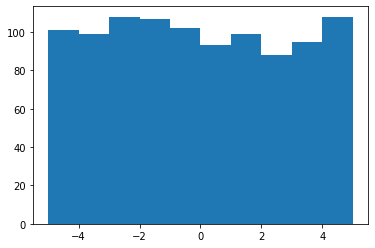

In [43]:
sampler = LTSStaticUserSampler()
starting_nke = []
for i in range(1000):
  sampled_user = sampler.sample_user()
  starting_nke.append(sampled_user.net_genre_exposure)
_ = plt.hist(starting_nke)

Response Model

In [44]:
class LTSResponse(user.AbstractResponse):
  # The maximum degree of engagement.
  MAX_ENGAGEMENT_MAGNITUDE = 100.0

  def __init__(self, clicked=False, engagement=0.0):
    self.clicked = clicked
    self.engagement = engagement

  def create_observation(self):
    return {'click': int(self.clicked), 'engagement': np.array(self.engagement)}

  @classmethod
  def response_space(cls):
    # `engagement` feature range is [0, MAX_ENGAGEMENT_MAGNITUDE]
    return spaces.Dict({
        'click':
            spaces.Discrete(2),
        'engagement':
            spaces.Box(
                low=0.0,
                high=cls.MAX_ENGAGEMENT_MAGNITUDE,
                shape=tuple(),
                dtype=np.float32)
    })

In [45]:
def user_init(self,
              slate_size,
              seed=0):

  super(LTSUserModel,
        self).__init__(LTSResponse,
                       LTSStaticUserSampler(LTSUserState,
                                            seed=seed), slate_size)
  self.choice_model = MultinomialLogitChoiceModel({})


In [46]:
def simulate_response(self, slate_documents):
  # List of empty responses
  responses = [self._response_model_ctor() for _ in slate_documents]
  # Get click from of choice model.
  self.choice_model.score_documents(
    self._user_state, [doc.create_observation() for doc in slate_documents])
  scores = self.choice_model.scores
  selected_index = self.choice_model.choose_item()
  # Populate clicked item.
  self._generate_response(slate_documents[selected_index],
                          responses[selected_index])
  return responses

def generate_response(self, doc, response):
  response.clicked = True
  # linear interpolation between choc and genre.
  engagement_loc = (doc.genre * self._user_state.choc_mean
                    + (1 - doc.genre) * self._user_state.genre_mean)
  engagement_loc *= self._user_state.satisfaction
  engagement_scale = (doc.genre * self._user_state.choc_stddev
                      + ((1 - doc.genre)
                          * self._user_state.genre_stddev))
  log_engagement = np.random.normal(loc=engagement_loc,
                                    scale=engagement_scale)
  response.engagement = np.exp(log_engagement)

In [47]:
def update_state(self, slate_documents, responses):
  for doc, response in zip(slate_documents, responses):
    if response.clicked:
      innovation = np.random.normal(scale=self._user_state.innovation_stddev)
      net_genre_exposure = (self._user_state.memory_discount
                                * self._user_state.net_genre_exposure
                                - 2.0 * (doc.genre - 0.5)
                                + innovation
                              )
      self._user_state.net_genre_exposure = net_genre_exposure
      satisfaction = 1 / (1.0 + np.exp(-self._user_state.sensitivity
                                        * net_genre_exposure)
                          )
      self._user_state.satisfaction = satisfaction
      self._user_state.time_budget -= 1
      return

In [48]:
def is_terminal(self):
  """Returns a boolean indicating if the session is over."""
  return self._user_state.time_budget <= 0

In [49]:
LTSUserModel = type("LTSUserModel", (user.AbstractUserModel,),
                    {"__init__": user_init,
                     "is_terminal": is_terminal,
                     "update_state": update_state,
                     "simulate_response": simulate_response,
                     "_generate_response": generate_response})

In [50]:
slate_size = 3
num_candidates = 10
ltsenv = environment.Environment(
            LTSUserModel(slate_size),
            LTSDocumentSampler(),
            num_candidates,
            slate_size,
            resample_documents=True)

/tmp/ipykernel_4070978/3447439163.py:9: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  music_features['genre'] = self._rng.random_integers(10)


In [51]:
def clicked_engagement_reward(responses):
  reward = 0.0
  for response in responses:
    if response.clicked:
      reward += response.engagement
  return reward

In [52]:
lts_gym_env = recsim_gym.RecSimGymEnv(ltsenv, clicked_engagement_reward)

In [54]:
observation_0 = lts_gym_env.reset()
print('Observation 0')
print('Available documents')
doc_strings = ['music_id ' + key + " genre " + str(value) for key, value
               in observation_0['doc'].items()]
print('\n'.join(doc_strings))
print('Noisy user state observation')
print(observation_0['user'])
# Agent recommends the first three documents.
recommendation_slate_0 = [0, 1, 2]
observation_1, reward, done, _ = lts_gym_env.step(recommendation_slate_0)
print('Observation 1')
print('Available documents')
doc_strings = ['music_id ' + key + " genre " + str(value) for key, value
               in observation_1['doc'].items()]
print('\n'.join(doc_strings))
rsp_strings = [str(response) for response in observation_1['response']]
print('User responses to documents in the slate')
print('\n'.join(rsp_strings))
print('Noisy user state observation')
print(observation_1['user'])

Observation 0
Available documents
music_id 30 genre 3
music_id 31 genre 4
music_id 32 genre 9
music_id 33 genre 2
music_id 34 genre 4
music_id 35 genre 4
music_id 36 genre 4
music_id 37 genre 8
music_id 38 genre 1
music_id 39 genre 2
Noisy user state observation
[0.31345803]
Observation 1
Available documents
music_id 40 genre 10
music_id 41 genre 10
music_id 42 genre 1
music_id 43 genre 5
music_id 44 genre 8
music_id 45 genre 4
music_id 46 genre 3
music_id 47 genre 8
music_id 48 genre 3
music_id 49 genre 1
User responses to documents in the slate
{'click': 1, 'engagement': array(21.3065692)}
{'click': 0, 'engagement': array(0.)}
{'click': 0, 'engagement': array(0.)}
Noisy user state observation
[0.50317804]


/tmp/ipykernel_4070978/3447439163.py:9: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  music_features['genre'] = self._rng.random_integers(10)
